<h4 align="right">30th of March 2020</h4>
<h1 align="center">Neural Networks and Deep Learning (CIE 555)</h1>
<h2 align="center">Lab 8: Recurrent Neural Networks</h2>
<h3 align="center">Part 1: Text Application</h3><br>

sources : https://stackabuse.com/python-for-nlp-movie-sentiment-analysis-using-deep-learning-in-keras/



In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

from numpy import array
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM 
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer

## uploading & data exploration
<br>
download data from : https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
<br>
or google drive : 
https://drive.google.com/file/d/1DxXTx1jVhW4ZpKwOAjcJDVF7ZwIA4kky/view?usp=sharing

In [2]:
!wget -O IMDBDataset.csv https://drive.google.com/uc?id=1DxXTx1jVhW4ZpKwOAjcJDVF7ZwIA4kky&export=download

--2020-03-30 23:28:30--  https://drive.google.com/uc?id=1DxXTx1jVhW4ZpKwOAjcJDVF7ZwIA4kky
Resolving drive.google.com (drive.google.com)... 173.194.202.101, 173.194.202.102, 173.194.202.139, ...
Connecting to drive.google.com (drive.google.com)|173.194.202.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-10-44-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/pnncsmpf82s36r2dhc0seds3f7rg9lor/1585610850000/01482955439632590342/*/1DxXTx1jVhW4ZpKwOAjcJDVF7ZwIA4kky [following]
--2020-03-30 23:28:38--  https://doc-10-44-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/pnncsmpf82s36r2dhc0seds3f7rg9lor/1585610850000/01482955439632590342/*/1DxXTx1jVhW4ZpKwOAjcJDVF7ZwIA4kky
Resolving doc-10-44-docs.googleusercontent.com (doc-10-44-docs.googleusercontent.com)... 74.125.195.132, 2607:f8b0:400e:c09::84
Connecting to doc-10-44-docs.googleusercontent.com (doc-10-44-docs.googleusercontent.com)|74

In [3]:
movie_reviews = pd.read_csv("IMDBDataset.csv")
movie_reviews.isnull().values.any()
movie_reviews.shape

(50000, 2)

In [4]:
movie_reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
movie_reviews["review"][3]

"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them."

## Preprocessing & data split

In [0]:
TAG_RE = re.compile(r'<[^>]+>')
def remove_tags(text):
    return TAG_RE.sub('', text)

def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence


In [0]:
X = []
#apply preprocess_text to remove HTML tags, punctuations and numbers.
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

# one hot encoding for Y (as lampda function)
y = movie_reviews['sentiment']
y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

### convert text to int
In the word-to-index dictionary, each word in the corpus is used as a key, while a corresponding unique index is used as the value for the key.

In [0]:
# create a word-to-index dictionary by fitting it on X_train to see all vocab
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

#perform the tokenization (replace each word by its corresponding index)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

***X_train now*** contains 40,000 lists where each list contains integers.
<br>
Each list corresponds to each sentence in the training set which have **different size**
<br>
the LSTM needs fixed size input so we need to perform (truncation/padding). We set that size to 100 for each list.

In [0]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1 #this variable will be used later

maxlen = 100 # maximum length of the sentence in WORDS

X_train1 = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test1 = pad_sequences(X_test, padding='post', maxlen=maxlen)


In [11]:
#preview the lists all of size 100 (100 word for every trainig sample)
pd.DataFrame(X_train1).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,4,1,296,140,2854,2,405,614,1,263,5,3514,977,4,25,37,11,1237,215,62,2,35,5,27,217,24,189,1430,7,1068,15,4868,81,1,221,63,351,64,52,24,...,71,218,4,321,2,3431,31,20,47,68,1844,4668,11,6,1365,8,16,5,3475,1990,14,59,1,2380,460,518,2,170,2524,2698,1745,4,573,6,33,1,3750,198,345,3812
1,1,412,100,20,155,81,17,46,14,1,98,4696,2,2508,1560,2,1,864,1,100,639,51,7,5,19,188,403,1,546,9,21,5,4342,51,7,1810,585,4,2408,417,...,1,12,2,628,4808,5,1082,541,13,259,4,2408,897,2,1,204,132,1181,32,700,2,26,1,603,455,220,94,1052,8,12,91,23,71,1681,15,6,211,82,99,6
2,128,1307,108,58,2791,3,7,1,1248,13,108,4512,2550,18,1668,3890,2,80,8,5,327,29,4164,74,4,1319,4,249,76,1,58,2711,18,31,481,32,69,4,25,2176,...,1,1308,1741,1,2263,7,22,286,1483,2,80,21,14,1,1487,9,389,84,310,2,695,58,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1663,777,57,59,924,7,44,1974,950,1164,3355,57,376,754,264,30,1318,1746,1326,31,376,529,1135,491,19,4,736,745,701,39,3,1,1320,3,251,7,8,407,1,103,...,3,3626,13,1,57,6,3735,7,430,752,2,9,6,5,1428,4,1563,2543,51,1,2037,15,610,94,1064,276,3,2,36,1415,14,57,2990,2628,63,29,87,428,332,3432
4,5,1,2,6,5,127,1072,9,1334,23,210,4,231,23,102,8,7,104,76,93,11,65,26,1,53,17,37,114,89,164,4,125,65,26,98,20,622,11,28,20,...,657,13,2468,27,26,26,7,26,46,130,9,1760,14,70,546,96,309,8,12,6,10,1,24,12,9,86,64,942,9,66,233,350,44,167,537,7,12,226,169,646


## Embedding Layer

In [12]:
#download glove
!wget 'http://nlp.stanford.edu/data/glove.6B.zip'

--2020-03-30 23:29:03--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-03-30 23:29:03--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-03-30 23:29:04--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [13]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [0]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

#create a dictionary that will contain words as keys and their corresponding embedding list as values.
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()


 create an embedding matrix where each row number will correspond to the index of the word in the corpus. The matrix will have 100 columns where each column will contain the GloVe word embedding for the words in our corpus.

In [0]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector


In [16]:
embedding_matrix[0][0]

0.0

embedding_matrix will contain 92547 rows (one for each word in the corpus). Now we are ready to create our deep learning models.

# Simple Neural Network

In [29]:
model1 = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model1.add(embedding_layer)
model1.add(Flatten())
model1.add(Dense(1, activation='sigmoid'))

model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model1.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          9254700   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 10001     
Total params: 9,264,701
Trainable params: 10,001
Non-trainable params: 9,254,700
_________________________________________________________________
None


In [30]:
history = model1.fit(X_train1, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 1s 4ms/step - loss: 0.6030 - acc: 0.6710 - val_loss: 0.5627 - val_acc: 0.7046
Epoch 2/6
250/250 [==============================] - 1s 4ms/step - loss: 0.4969 - acc: 0.7599 - val_loss: 0.5272 - val_acc: 0.7355
Epoch 3/6
250/250 [==============================] - 1s 4ms/step - loss: 0.4582 - acc: 0.7874 - val_loss: 0.5279 - val_acc: 0.7399
Epoch 4/6
250/250 [==============================] - 1s 4ms/step - loss: 0.4371 - acc: 0.7995 - val_loss: 0.5332 - val_acc: 0.7400
Epoch 5/6
250/250 [==============================] - 1s 4ms/step - loss: 0.4217 - acc: 0.8088 - val_loss: 0.5239 - val_acc: 0.7486
Epoch 6/6
250/250 [==============================] - 1s 4ms/step - loss: 0.4093 - acc: 0.8166 - val_loss: 0.5365 - val_acc: 0.7398


In [31]:
score = model1.evaluate(X_test1, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

313/313 [==============================] - 1s 2ms/step - loss: 0.5413 - acc: 0.7415
Test Score: 0.5412882566452026
Test Accuracy: 0.7415000200271606


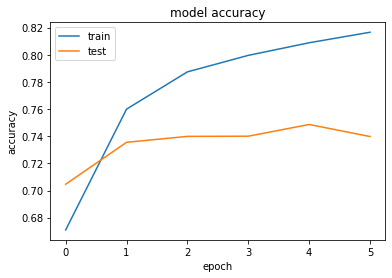

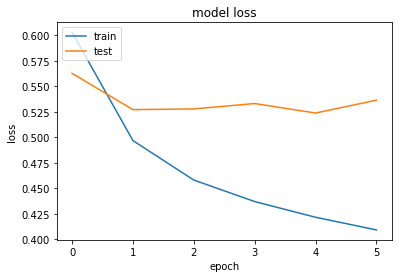

In [32]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# Recurrent Neural Network (LSTM)

In [33]:
model2 = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model2.add(embedding_layer)
model2.add(LSTM(128))
model2.add(Dense(1, activation='sigmoid'))

model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model2.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 100)          9254700   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 9,372,077
Trainable params: 117,377
Non-trainable params: 9,254,700
_________________________________________________________________
None


In [34]:
history = model2.fit(X_train1, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)


Epoch 1/6
250/250 [==============================] - 77s 308ms/step - loss: 0.5688 - acc: 0.7030 - val_loss: 0.5116 - val_acc: 0.7709
Epoch 2/6
250/250 [==============================] - 77s 307ms/step - loss: 0.4505 - acc: 0.7903 - val_loss: 0.4117 - val_acc: 0.8149
Epoch 3/6
250/250 [==============================] - 77s 307ms/step - loss: 0.4016 - acc: 0.8168 - val_loss: 0.4337 - val_acc: 0.7924
Epoch 4/6
250/250 [==============================] - 76s 305ms/step - loss: 0.3689 - acc: 0.8358 - val_loss: 0.3599 - val_acc: 0.8430
Epoch 5/6
250/250 [==============================] - 76s 305ms/step - loss: 0.3398 - acc: 0.8535 - val_loss: 0.3675 - val_acc: 0.8370
Epoch 6/6
250/250 [==============================] - 77s 308ms/step - loss: 0.3231 - acc: 0.8597 - val_loss: 0.3310 - val_acc: 0.8540


In [35]:
score = model2.evaluate(X_test1, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

313/313 [==============================] - 10s 31ms/step - loss: 0.3301 - acc: 0.8575
Test Score: 0.3301003575325012
Test Accuracy: 0.8575000166893005


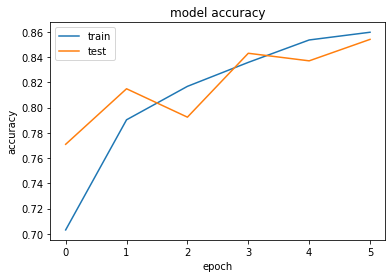

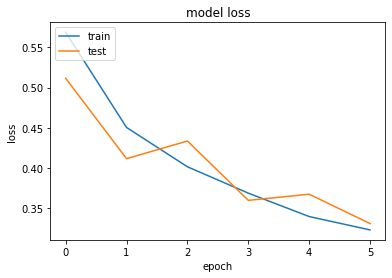

In [36]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# test your own review

In [38]:
instance = '''I laughed all the way through this rotten movie It so unbelievable
              woman leaves her husband after many years of marriage has breakdown 
              in front of real estate office What happens The office manager comes 
              outside and offers her job Hilarious Next thing you know the two 
              women are going at it Yep they re lesbians Nothing rings true in 
              this Lifetime for Women with nothing better to do movie Clunky 
              dialogue like don want to spend the rest of my life feeling like 
              had chance to be happy and didn take it doesn help There a wealthy 
              distant mother who disapproves of her daughter new relationship 
              sassy black maid unbelievable that in the year film gets made in 
              which there a sassy black maid Hattie McDaniel must be turning in 
              her grave The woman has husband who freaks out and wants custody 
              of the snotty teenage kids Sheesh No cliche is left unturned '''
instance = tokenizer.texts_to_sequences(instance)

flat_list = []
for sublist in instance:
    for item in sublist:
        flat_list.append(item)

flat_list = [flat_list]

instance = pad_sequences(flat_list, padding='post', maxlen=maxlen)

model2.predict(instance)




array([[0.12230082]], dtype=float32)

## Task: 
use glove-200d or 300d (increase input dimension) 
<br> *Note: you may need to use more epocs and different sentence length to achive higher accuracy.*

In [0]:
maxleng= 150
X_train2 = pad_sequences(X_train, padding='post', maxlen=maxleng)
X_test2 = pad_sequences(X_test, padding='post', maxlen=maxleng)

In [0]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('glove.6B.200d.txt', encoding="utf8")

#create a dictionary that will contain words as keys and their corresponding embedding list as values.
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()


In [0]:
embedding_matrix2 = zeros((vocab_size, 200))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix2[index] = embedding_vector

In [42]:
embedding_matrix2[0][0]

0.0

In [50]:
model3 = Sequential()
embedding_layer = Embedding(vocab_size, 200, weights=[embedding_matrix2], input_length=maxleng , trainable=False)
model3.add(embedding_layer)
model3.add(LSTM(256))
model3.add(Dense(1, activation='sigmoid'))

model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          9254700   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 9,372,077
Trainable params: 117,377
Non-trainable params: 9,254,700
_________________________________________________________________
None


In [51]:
history = model3.fit(X_train2, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)


Epoch 1/10
250/250 [==============================] - 319s 1s/step - loss: 0.6289 - acc: 0.6451 - val_loss: 0.5750 - val_acc: 0.7226
Epoch 2/10
250/250 [==============================] - 319s 1s/step - loss: 0.5761 - acc: 0.7216 - val_loss: 0.6914 - val_acc: 0.5220
Epoch 3/10
250/250 [==============================] - 318s 1s/step - loss: 0.6225 - acc: 0.6559 - val_loss: 0.4943 - val_acc: 0.7756
Epoch 4/10
250/250 [==============================] - 315s 1s/step - loss: 0.4707 - acc: 0.7838 - val_loss: 0.3620 - val_acc: 0.8443
Epoch 5/10
250/250 [==============================] - 315s 1s/step - loss: 0.3575 - acc: 0.8424 - val_loss: 0.3330 - val_acc: 0.8547
Epoch 6/10
250/250 [==============================] - 315s 1s/step - loss: 0.3287 - acc: 0.8589 - val_loss: 0.3074 - val_acc: 0.8671
Epoch 7/10
250/250 [==============================] - 322s 1s/step - loss: 0.3078 - acc: 0.8682 - val_loss: 0.3292 - val_acc: 0.8545
Epoch 8/10
250/250 [==============================] - 320s 1s/step - 

In [52]:
score = model3.evaluate(X_test2, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

313/313 [==============================] - 55s 176ms/step - loss: 0.2813 - acc: 0.8801
Test Score: 0.2813138961791992
Test Accuracy: 0.8801000118255615


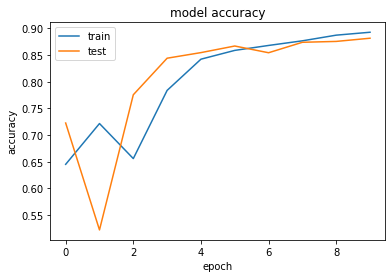

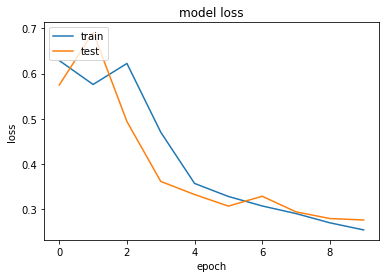

In [53]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()